In [19]:
# Styling and helper functions for consistent graphs
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np
from matplotlib.colors import ListedColormap

# Set a clean seaborn style and matplotlib rcParams for consistency
def _set_style():
    sns.set(style="whitegrid")
    mpl.rcParams.update({
        'figure.figsize': (14, 8),
        'axes.titlesize': 16,
        'axes.labelsize': 12,
        'xtick.labelsize': 11,
        'ytick.labelsize': 11,
        'legend.fontsize': 11,
        'grid.color': '#dddddd',
        'grid.linestyle': '--',
        'grid.alpha': 0.5,
        # Font family: prefer modern visualization fonts; matplotlib will fallback if not installed
        'font.family': 'sans-serif',
        'font.sans-serif': ['Inter', 'Roboto', 'DejaVu Sans', 'Arial', 'Helvetica'],
        # Make titles and labels slightly bolder for clarity
        'axes.titleweight': '600',
        'axes.labelweight': '500',
        # Legend title size (works with newer matplotlib versions)
        'legend.title_fontsize': 12,
    })

# Color palette (colorblind-friendly) - used for categorical mappings
PALETTE = sns.color_palette("colorblind")
PALETTE_HEX = [sns.utils.hex_rgb(c) if isinstance(c, str) else '#%02x%02x%02x' % tuple([int(255*x) for x in c]) for c in PALETTE]

_set_style()

def plot_scatter(df, x, y, color_by=None, color_by_title=None, categorical=False, cmap='viridis',
                 title='', xlabel='', ylabel='', size=20, alpha=0.75, show_legend=True, cb_label=None,
                 legend_labels=None, legend_label_func=None):
    """Helper scatter plot with consistent style.
    - If `categorical` is True, `color_by` is treated as categories and colored using `PALETTE`.
      By default the legend labels are the raw category values (e.g. the `trip_short` strings).
      You can customize legend text with `legend_labels` (dict mapping category->label)
      or `legend_label_func` (callable taking category -> label).
    - Otherwise `color_by` is numeric and a continuous `cmap` is used. Non-numeric inputs
      will be coerced to numeric via `pd.to_numeric(..., errors='coerce')`.
    """
    fig, ax = plt.subplots()

    if color_by is None:
        sc = ax.scatter(df[x], df[y], c='tab:blue', s=size, alpha=alpha)
    else:
        if categorical:
            # Map categories to palette indices
            cats = pd.Categorical(df[color_by])
            codes = cats.codes
            cmap_list = PALETTE[:max(1, len(cats.categories))]
            cmap_list = list(cmap_list)  # ensure list
            sc = ax.scatter(df[x], df[y], c=codes, cmap=ListedColormap(cmap_list), s=size, alpha=alpha)
            if show_legend:
                # By default use the raw category values for legend labels
                if legend_labels is None and legend_label_func is None:
                    labels = [str(cat) for cat in cats.categories]
                else:
                    def _label_for(cat):
                        if isinstance(legend_labels, dict) and cat in legend_labels:
                            return legend_labels[cat]
                        if callable(legend_label_func):
                            try:
                                return legend_label_func(cat)
                            except Exception:
                                return str(cat)
                        return str(cat)

                    labels = [_label_for(cat) for cat in cats.categories]

                handles = [mpl.patches.Patch(color=PALETTE[i % len(PALETTE)], label=labels[i]) for i in range(len(cats.categories))]
                ncol = min(5, max(1, len(cats.categories)))
                legend_title = color_by_title if color_by_title is not None else color_by
                ax.legend(handles=handles, title=legend_title, loc='upper center', bbox_to_anchor=(0.5, -0.18), ncol=ncol, frameon=False)
        else:
            # numeric color scale; coerce to numeric to avoid ValueError when column is str
            values = pd.to_numeric(df[color_by], errors='coerce')
            sc = ax.scatter(df[x], df[y], c=values, cmap=cmap, s=size, alpha=alpha)
            if cb_label is not None:
                cb = fig.colorbar(sc, ax=ax)
                cb.set_label(cb_label)

    # horizontal zero line
    ax.axhline(0, color='#d62728', linestyle='--', linewidth=1)

    # x-axis formatting: if numeric hours, format as HH:00 when sensible
    try:
        min_x = int(np.nanmin(df[x]))
        max_x = int(np.nanmax(df[x]))
        ax.set_xticks(range(min_x, max_x + 1))
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda val, _: f'{int(val):02d}:00'))
    except Exception:
        pass

    ax.set_title(title)
    if xlabel: ax.set_xlabel(xlabel)
    if ylabel: ax.set_ylabel(ylabel)
    ax.grid(True)
    # Reserve space at the bottom for a horizontal legend (if present)
    fig.tight_layout(rect=[0, 0.12, 1, 0.95])
    plt.show()

# Expose the palette for quick reference
PALETTE


[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

## Load and filter data
Load the observations and keep only Caltrain (`CT:`) trip IDs.

In [7]:
# Load observations from all 511 zip archives under trial/, concatenate, and add source month
import os, re, glob, zipfile, io

# Find monthly archives anywhere under trial/
zip_paths = []
zip_paths.extend(glob.glob(os.path.join('trial', '511_data_*.zip')))
zip_paths.extend(glob.glob(os.path.join('trial', '**', '511_data_*.zip'), recursive=True))
zip_paths = sorted(set(zip_paths))

# Columns we need downstream for cleaning/plots
wanted_cols = [
    'trip_id', 'route_id', 'stop_sequence',
    'scheduled_arrival_time', 'observed_arrival_time',
    'scheduled_departure_time', 'observed_departure_time',
]

frames = []
for zp in zip_paths:
    m = re.search(r'511_data_(\d{4}-\d{2})', os.path.basename(zp))
    obs_month = m.group(1) if m else 'unknown'
    target = 'stop_observations.txt'
    try:
        with zipfile.ZipFile(zp) as zf:
            if target not in zf.namelist():
                print(f"Warning: '{target}' not found in {zp}")
                continue
            # Read header to determine available columns safely
            with zf.open(target) as fh:
                with io.TextIOWrapper(fh, encoding='utf-8') as txt:
                    try:
                        header_df = pd.read_csv(txt, nrows=0, low_memory=False)
                        available = list(header_df.columns)
                    except Exception as e:
                        print(f"Error reading header in {zp}: {e}")
                        continue
            usecols = [c for c in wanted_cols if c in available]
            if len(usecols) == 0:
                print(f"Warning: no wanted columns present in {zp}; skipping")
                continue
            # Stream rows in chunks to control memory; coerce to strings to avoid dtype bloat
            with zf.open(target) as fh:
                with io.TextIOWrapper(fh, encoding='utf-8') as txt:
                    for chunk in pd.read_csv(
                        txt,
                        usecols=usecols,
                        dtype=str,
                        chunksize=100_000,
                        low_memory=False,
                        on_bad_lines='skip',
                    ):
                        # Early filter to Caltrain to reduce memory footprint
                        if 'trip_id' in chunk.columns:
                            chunk = chunk[chunk['trip_id'].str.startswith('CT:', na=False)]
                        if chunk.empty:
                            continue
                        chunk['obs_month'] = obs_month
                        frames.append(chunk)
            print(f"Processed {zp} ({obs_month})")
    except Exception as e:
        print(f"Error reading {zp}: {e}")

if len(frames) == 0:
    # Fallback to plain file if no usable zips found
    fallback_path = os.path.join('trial', 'stop_observations.txt')
    if os.path.exists(fallback_path):
        df = pd.read_csv(fallback_path, dtype=str, low_memory=False)
        # Early filter
        if 'trip_id' in df.columns:
            df = df[df['trip_id'].str.startswith('CT:', na=False)]
        df['obs_month'] = 'unknown'
        print(f"Loaded fallback file with {len(df)} rows")
    else:
        raise FileNotFoundError("No 511_data_*.zip archives or fallback stop_observations.txt found under 'trial/'")
else:
    df = pd.concat(frames, ignore_index=True)
    print(f"Loaded {len(zip_paths)} zip(s); concatenated filtered rows: {len(df)}")

# Do not save here; cleaning and filtering happen in the next cell

Processed trial\511_data_2025-03.zip (2025-03)
Processed trial\511_data_2025-03.zip (2025-03)
Processed trial\511_data_2025-04.zip (2025-04)
Processed trial\511_data_2025-04.zip (2025-04)
Processed trial\511_data_2025-05.zip (2025-05)
Processed trial\511_data_2025-05.zip (2025-05)
Processed trial\511_data_2025-06.zip (2025-06)
Processed trial\511_data_2025-06.zip (2025-06)
Processed trial\511_data_2025-07.zip (2025-07)
Processed trial\511_data_2025-07.zip (2025-07)
Processed trial\511_data_2025-08.zip (2025-08)
Processed trial\511_data_2025-08.zip (2025-08)
Processed trial\511_data_2025-09.zip (2025-09)
Processed trial\511_data_2025-09.zip (2025-09)
Processed trial\511_data_2025-10.zip (2025-10)
Processed trial\511_data_2025-10.zip (2025-10)
Loaded 70 zip(s); concatenated filtered rows: 378181
Loaded 70 zip(s); concatenated filtered rows: 378181


## Clean and parse time columns
Parse time columns, drop rows with missing parsed times, and compute delay columns in minutes.

In [20]:
# Define expected time columns
time_cols = [
    'scheduled_arrival_time',
    'observed_arrival_time',
    'scheduled_departure_time',
    'observed_departure_time',
]
print(df)
# Parse times; many feeds provide HH:MM:SS strings — coerce errors to NaT
for col in time_cols:
    df[col + '_dt'] = pd.to_datetime(df[col], format='%H:%M:%S', errors='coerce')

# Keep rows where all parsed times are present
valid = df[[c + '_dt' for c in time_cols]].notna().all(axis=1)
df = df[valid].copy()
print(f'Rows after parsing times: {len(df)}')

# Compute delay in minutes for arrivals and departures
df['arr_diff_min'] = (df['observed_arrival_time_dt'] - df['scheduled_arrival_time_dt']).dt.total_seconds() / 60.0
df['dep_diff_min'] = (df['observed_departure_time_dt'] - df['scheduled_departure_time_dt']).dt.total_seconds() / 60.0

# Prepare a numeric 'departure_hour' for consistent x-axis plotting
df['departure_hour'] = df['scheduled_departure_time_dt'].dt.hour + df['scheduled_departure_time_dt'].dt.minute / 60.0

# Create a compact trip label from `trip_id`: extract the middle code (e.g. '102') and keep first and last digits
# Example: 'CT:102:20250101' -> trip_code='102' -> trip_short='1-2'
df['trip_code'] = df['trip_id'].str.extract(r'CT:([^:]+):', expand=False).fillna('')
df['trip_short'] = df['trip_code'].astype(str).str[0].fillna('') + '-' + df['trip_code'].astype(str).str[-1].fillna('')
# Mark unknown/empty codes more clearly
df.loc[df['trip_code']=='', 'trip_short'] = 'unknown'

# Filter for Caltrain trips only (trip_id starts with 'CT:') after cleaning
df = df[df['trip_id'].str.startswith('CT:', na=False)].copy()
print(f'Rows after filtering CT trips: {len(df)}')

# Save cleaned data to CSV for reuse
df.to_csv('CT_filt.csv', index=False)
print('Saved cleaned dataset to CT_filt.csv')

                trip_id stop_sequence observed_arrival_time  \
0       CT:123:20250331             1              10:28:00   
1       CT:123:20250331             2              10:34:13   
2       CT:123:20250331             3              10:39:24   
3       CT:123:20250331             4              10:42:10   
4       CT:123:20250331             5              10:46:41   
...                 ...           ...                   ...   
378176  CT:522:20251031             6              17:48:10   
378177  CT:522:20251031             7              17:54:21   
378178  CT:522:20251031             8              18:00:22   
378179  CT:522:20251031             9              18:06:56   
378180  CT:522:20251031            10              18:10:38   

       observed_departure_time          route_id scheduled_arrival_time  \
0                     10:28:00  CT:Local Weekday               10:28:00   
1                     10:34:13  CT:Local Weekday               10:34:00   
2                 

## Scatter Plots of Train Delay


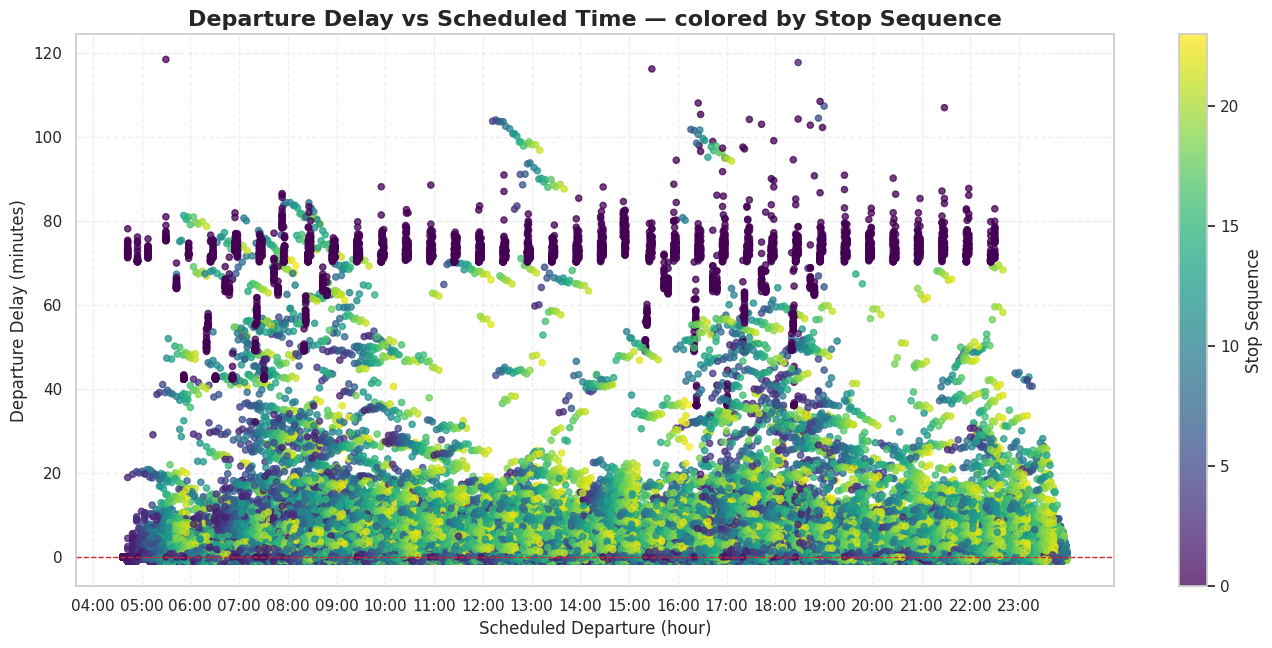

In [21]:
# Scatter colored by stop sequence (continuous colormap)
plot_scatter(df, x='departure_hour', y='dep_diff_min', color_by='stop_sequence', color_by_title="Stop Sequence", categorical=False, cmap='viridis',
             title='Departure Delay vs Scheduled Time — colored by Stop Sequence',
             xlabel='Scheduled Departure (hour)', ylabel='Departure Delay (minutes)', cb_label='Stop Sequence')


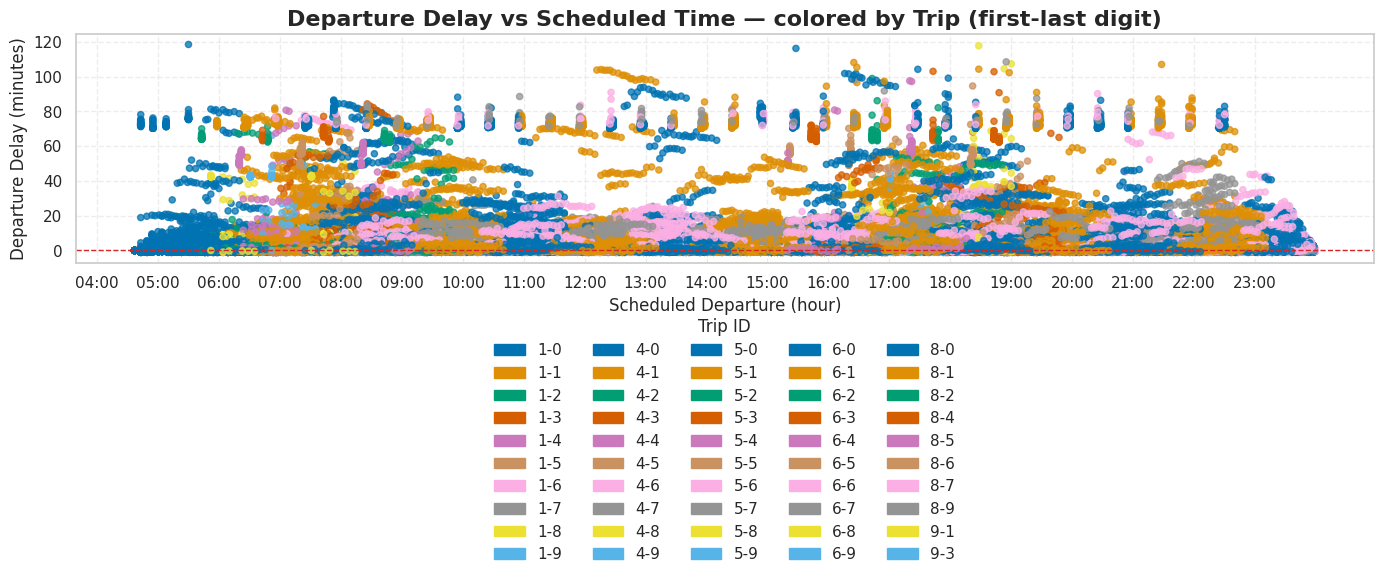

In [13]:
# Scatter colored by compact trip label (first and last digit of the trip code)
# Uses `trip_short` (e.g. '1-2' extracted from 'CT:102:...') for color and legend
plot_scatter(df, x='departure_hour', y='dep_diff_min', color_by='trip_short',color_by_title="Trip ID", categorical=True,
             title='Departure Delay vs Scheduled Time — colored by Trip (first-last digit)',
             xlabel='Scheduled Departure (hour)', ylabel='Departure Delay (minutes)')


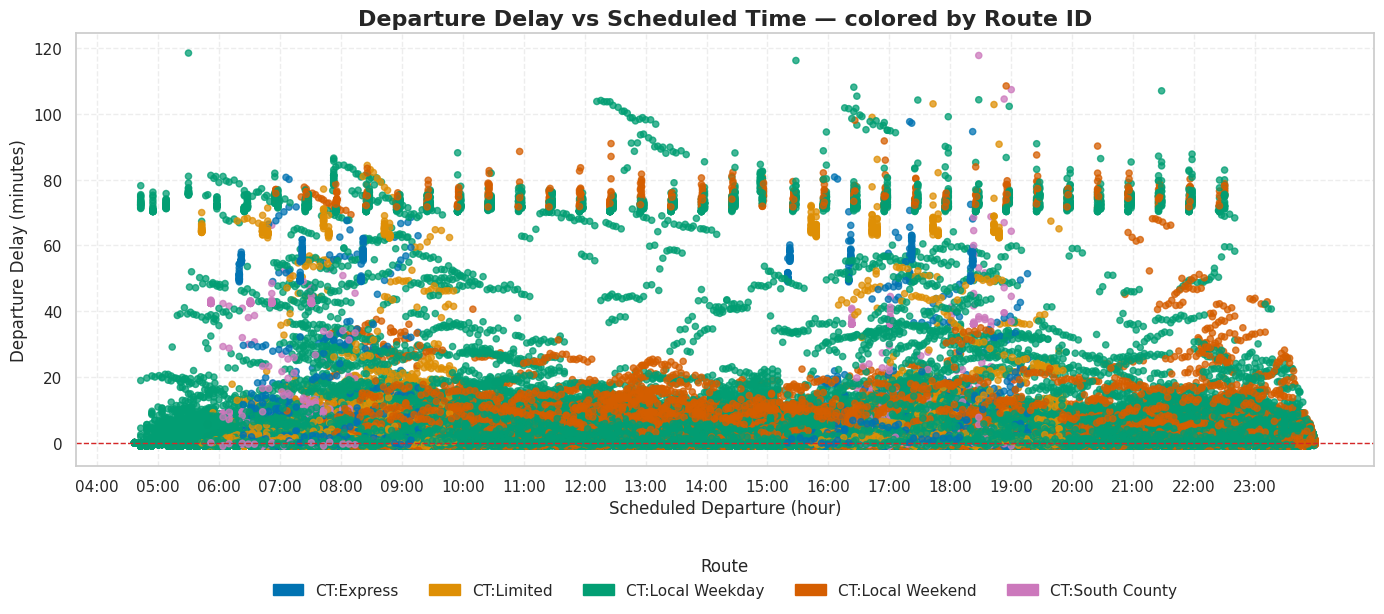

In [14]:
# Scatter colored by route_id (categorical) with legend
plot_scatter(df, x='departure_hour', y='dep_diff_min', color_by='route_id',color_by_title="Route", categorical=True,
             title='Departure Delay vs Scheduled Time — colored by Route ID',
             xlabel='Scheduled Departure (hour)', ylabel='Departure Delay (minutes)')


## KDE Plots of Train Delay between different Routes


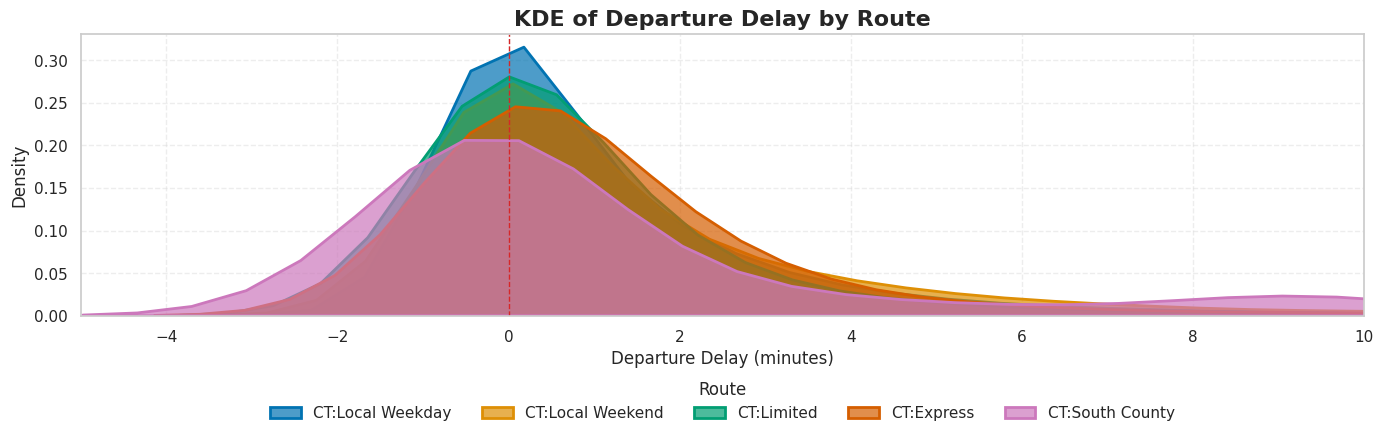

In [15]:
# KDE plot of departure delay by route_id
def plot_kde_by_route(df, value_col='dep_diff_min', category_col='route_id', top_n=6,
                      bw_method=None, fill=True, common_norm=False, figsize=(14, 6), xlim=(-5, 20)):
    """Plot KDEs of `value_col` for each route in `category_col`.
    - `top_n`: if set, limits to the `top_n` most frequent routes (by row count).
    - `bw_method`: passed to seaborn.kdeplot (None uses the default).
    - `fill`: whether to fill the KDE curve area.
    - `common_norm`: if True, areas are normalized together (useful for comparing counts); default False.
    - `xlim`: tuple (min, max) for x-axis limits, or None for auto.
    Returns (fig, ax).
    """
    if category_col not in df.columns:
        raise ValueError(f"Category column '{category_col}' not found in dataframe")
    if value_col not in df.columns:
        raise ValueError(f"Value column '{value_col}' not found in dataframe")

    counts = df[category_col].value_counts()
    if top_n is not None:
        routes = list(counts.index[:top_n])
    else:
        routes = list(counts.index)

    if len(routes) == 0:
        raise ValueError('No routes found to plot')

    # Build a palette re-using PALETTE (defined in notebook) if available, else fallback
    try:
        base_palette = list(PALETTE)
    except NameError:
        base_palette = sns.color_palette('tab10')
    # ensure we have enough colors
    palette = [base_palette[i % len(base_palette)] for i in range(len(routes))]

    fig, ax = plt.subplots(figsize=figsize)

    for i, route in enumerate(routes):
        vals = df.loc[df[category_col] == route, value_col].dropna()
        if len(vals) < 3:
            # skip categories with too few samples for KDE
            continue
        sns.kdeplot(
            data=vals,
            ax=ax,
            bw_method=bw_method,
            fill=fill,
            common_norm=common_norm,
            color=palette[i],
            label=str(route),
            linewidth=2,
            alpha=0.7,
        )

    ax.set_title(f'KDE of Departure Delay by Route', fontsize=16, fontweight='600')
    ax.set_xlabel('Departure Delay (minutes)', fontsize=12, fontweight='500')
    ax.set_ylabel('Density', fontsize=12, fontweight='500')
    ax.axvline(0, color='#d62728', linestyle='--', linewidth=1)
    ax.grid(True, linestyle='--', alpha=0.5)
    
    # Set x-axis limits if provided
    if xlim is not None:
        ax.set_xlim(xlim)

    # Horizontal legend at bottom
    handles, labels = ax.get_legend_handles_labels()
    if len(labels) > 0:
        ncol = min(6, max(1, len(labels)))
        ax.legend(handles=handles, labels=labels, title='Route',
                  loc='upper center', bbox_to_anchor=(0.5, -0.18), ncol=ncol, frameon=False)
        fig.tight_layout(rect=[0, 0.14, 1, 0.95])
    else:
        fig.tight_layout()

    return fig, ax

# Plot KDE for top 6 routes by frequency with x-axis limited to ±20 minutes
fig, ax = plot_kde_by_route(df, value_col='dep_diff_min', category_col='route_id', top_n=6, fill=True, xlim=(-5, 10))

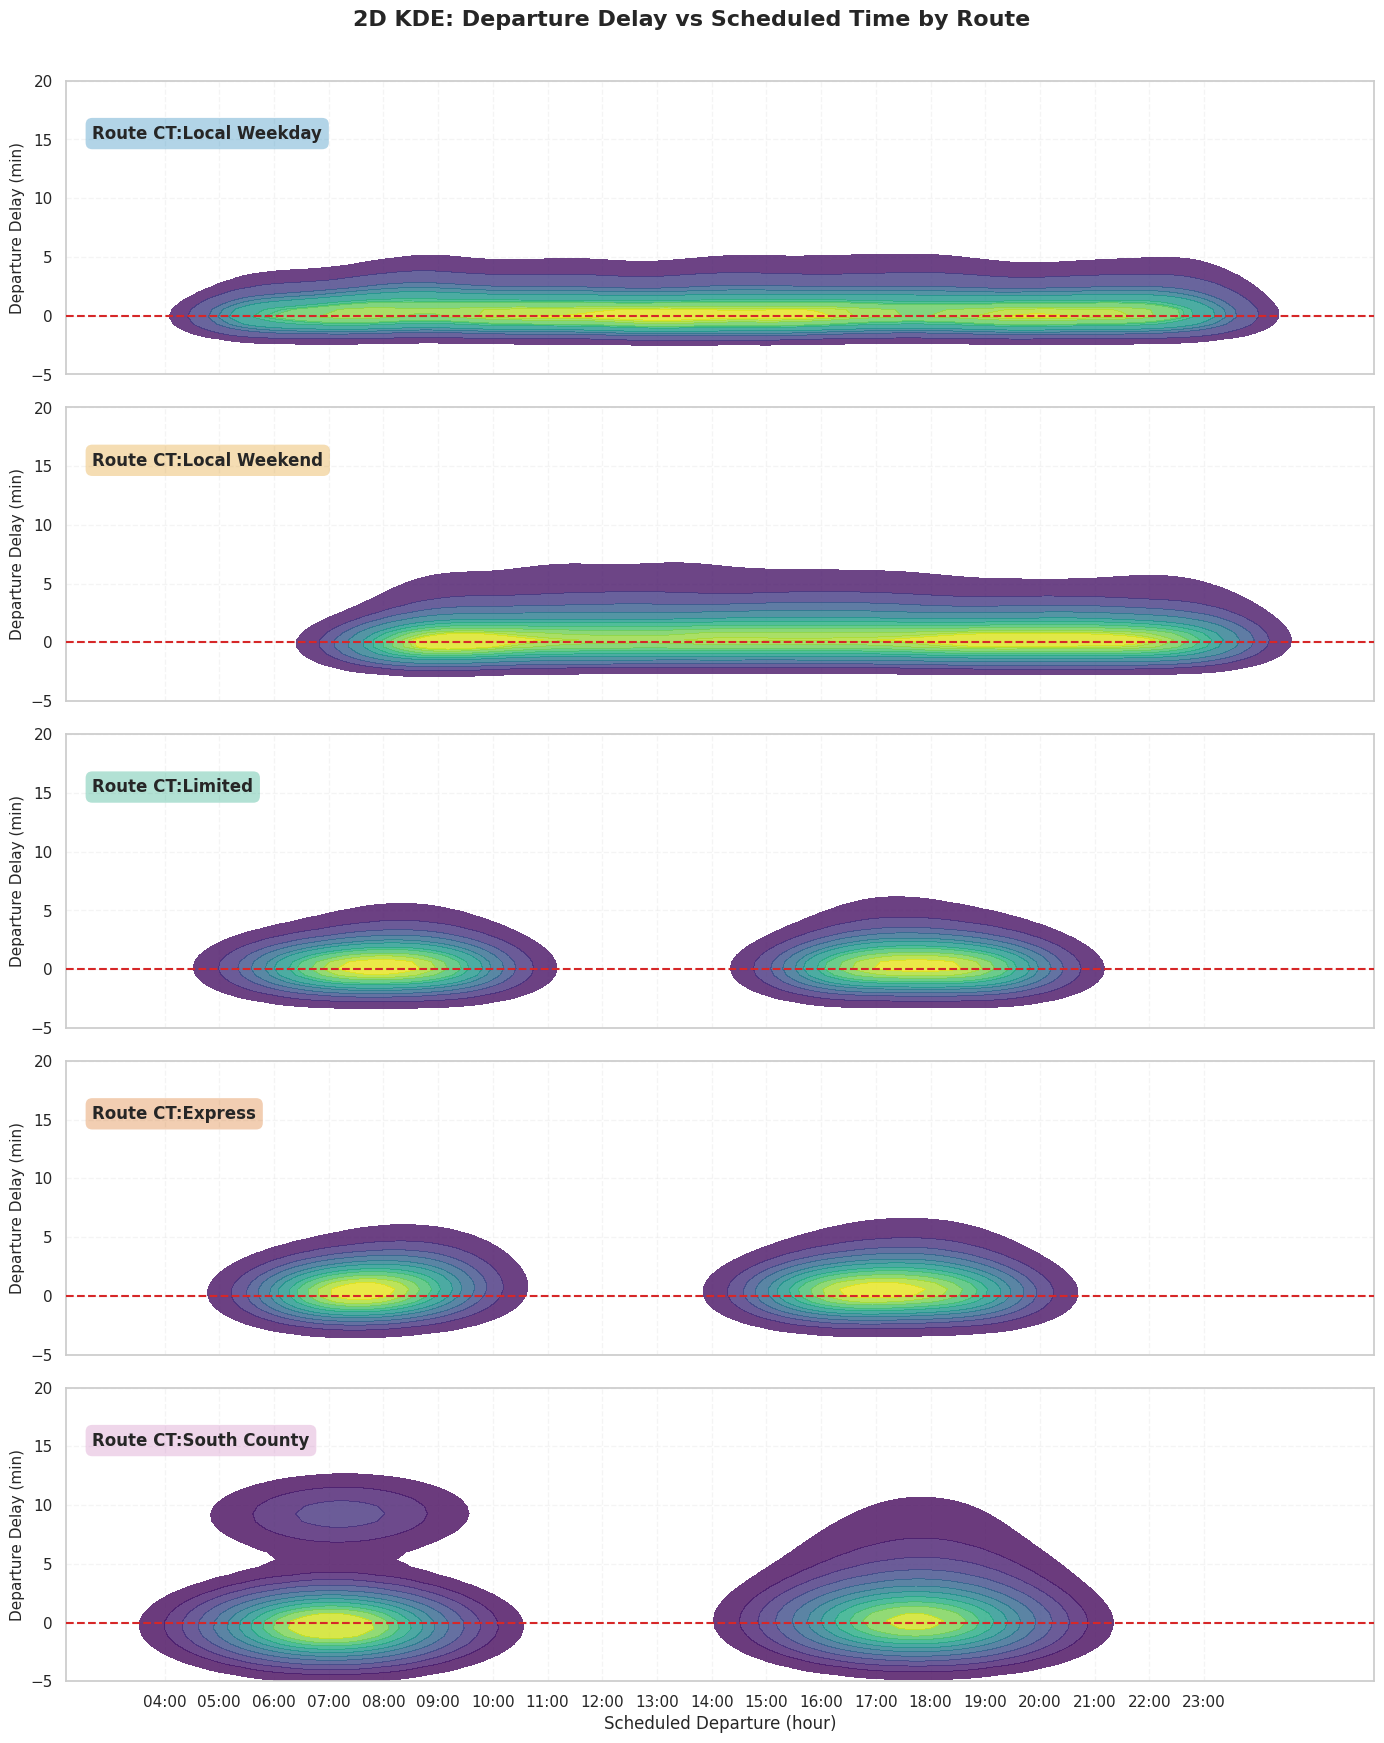

In [22]:
# 2D KDE plots for each route - stacked vertically with shared x-axis
def plot_2d_kde_by_route(df, x_col='departure_hour', y_col='dep_diff_min', 
                         category_col='route_id', top_n=6, levels=10, cmap='pastel', 
                         ylim=(-20, 20), subplot_height=3.5, sharex=True):
    """Create vertically stacked 2D KDE plots, one for each route.
    - `x_col`: column for x-axis (typically departure_hour).
    - `y_col`: column for y-axis (typically dep_diff_min).
    - `category_col`: column to group by (typically route_id).
    - `top_n`: if set, limits to the `top_n` most frequent routes (by row count).
    - `levels`: number of contour levels for the KDE.
    - `cmap`: colormap for the density plot.
    - `ylim`: tuple (min, max) for y-axis limits, or None for auto.
    - `subplot_height`: height of each subplot in inches.
    - `sharex`: if True, all subplots share the same x-axis (only bottom shows labels).
    Returns (fig, axes).
    """
    if category_col not in df.columns:
        raise ValueError(f"Category column '{category_col}' not found in dataframe")
    if x_col not in df.columns:
        raise ValueError(f"Column '{x_col}' not found in dataframe")
    if y_col not in df.columns:
        raise ValueError(f"Column '{y_col}' not found in dataframe")
    
    counts = df[category_col].value_counts()
    if top_n is not None:
        routes = list(counts.index[:top_n])
    else:
        routes = list(counts.index)
    
    if len(routes) == 0:
        raise ValueError('No routes found to plot')
    
    # Build a palette re-using PALETTE
    try:
        base_palette = list(PALETTE)
    except NameError:
        base_palette = sns.color_palette('tab10')
    palette = [base_palette[i % len(base_palette)] for i in range(len(routes))]
    
    # Create vertically stacked subplots
    n_routes = len(routes)
    figsize = (14, subplot_height * n_routes)
    fig, axes = plt.subplots(nrows=n_routes, ncols=1, figsize=figsize, sharex=sharex)
    
    # Ensure axes is always a list
    if n_routes == 1:
        axes = [axes]
    
    for i, route in enumerate(routes):
        ax = axes[i]
        route_df = df[df[category_col] == route][[x_col, y_col]].dropna()
        
        if len(route_df) < 10:
            # Not enough data for this route
            ax.text(0.5, 0.5, f'Route {route}: Insufficient data', 
                   ha='center', va='center', transform=ax.transAxes, fontsize=12)
            if ylim is not None:
                ax.set_ylim(ylim)
            continue
        
        # Create 2D KDE plot with higher threshold to filter out sparse regions
        sns.kdeplot(
            data=route_df,
            x=x_col,
            y=y_col,
            ax=ax,
            fill=True,
            cmap=cmap,
            levels=levels,
            alpha=0.8,
            thresh=0.1,  # Increased from 0.05 to filter out very sparse areas
        )
        
        # # Add scatter overlay with slightly higher alpha for visibility
        # ax.scatter(route_df[x_col], route_df[y_col], 
        #           c=palette[i], s=2, alpha=0.05, rasterized=True)
        
        # Horizontal zero line
        ax.axhline(0, color='#d62728', linestyle='--', linewidth=1.5, zorder=10)
        
        # Set y-axis limits
        if ylim is not None:
            ax.set_ylim(ylim)
        
        # Add route label in colored box
        ax.text(0.02, 0.85, f'Route {route}', transform=ax.transAxes, 
               fontsize=12, fontweight='600', ha='left', va='top',
               bbox=dict(boxstyle='round,pad=0.4', facecolor=palette[i], alpha=0.3, edgecolor='none'))
        
        ax.set_ylabel('Departure Delay (min)', fontsize=11, fontweight='500')
        ax.grid(True, linestyle='--', alpha=0.3)
        
        # Only show x-label and ticks on bottom subplot
        if i == n_routes - 1:
            # x-axis formatting: format as HH:00
            try:
                min_x = int(df[x_col].min())
                max_x = int(df[x_col].max())
                ax.set_xticks(range(min_x, max_x + 1))
                ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda val, _: f'{int(val):02d}:00'))
            except Exception:
                pass
            ax.set_xlabel('Scheduled Departure (hour)', fontsize=12, fontweight='500')
        else:
            ax.set_xlabel('')
    
    fig.suptitle('2D KDE: Departure Delay vs Scheduled Time by Route', 
                 fontsize=16, fontweight='600', y=0.995)
    fig.tight_layout(rect=[0, 0, 1, 0.99])
    
    return fig, axes

# Plot 2D KDE for top 6 routes stacked vertically
fig, axes = plot_2d_kde_by_route(df, x_col='departure_hour', y_col='dep_diff_min', 
                                  category_col='route_id', top_n=6, levels=12, 
                                  cmap='viridis', ylim=(-5, 20), subplot_height=3.5)
